In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def load_data(filepath, target_column):
    df = pd.read_csv(filepath)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y


train_filepath = "data_for_other_models_train.xls"
test_filepath = "data_for_other_models_test.xls"
target_column = "log_price"

X_train, y_train = load_data(train_filepath, target_column)
X_test, y_test = load_data(test_filepath, target_column)

In [34]:
categorical_columns = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'zipcode']

# Replace '1m' with NaN in categorical columns
X_train[categorical_columns] = X_train[categorical_columns].replace('1m', np.nan)
X_test[categorical_columns] = X_test[categorical_columns].replace('1m', np.nan)

# Fill missing values in categorical columns with the most frequent value (mode)
for col in categorical_columns:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_train[col].mode()[0])  # Use the mode from X_train for consistency

# Identify numerical columns (excluding categorical columns)
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Define the column transformer with both categorical and numerical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),  # Handle unknown categories
        ('num', StandardScaler(), numerical_columns)  # Apply scaling to numerical columns
    ])

# Create a pipeline that first applies the column transformer (preprocessing)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)  # Apply column transformations
])

# Transform the data
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

In [35]:
print(X_train.columns)

Index(['property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'host_identity_verified',
       'host_response_rate', 'instant_bookable', 'zipcode', 'bedrooms', 'beds',
       'Waterfront', 'Washer / Dryer', 'Pets allowed', 'Wireless Internet',
       'Air conditioning', 'Family/kid friendly', 'Dishwasher', 'Kitchen',
       'Beachfront', 'Heating', 'TV', 'Pool', 'num_years_hosting',
       'distance_to_Times_Square', 'distance_to_Empire_State_Building',
       'distance_to_Statue_of_Liberty', 'distance_to_Central_Park',
       'distance_to_JFK_Airport'],
      dtype='object')


In [51]:
print(y_pred_test[:10])  # Show the first 10 predictions
print(y_test[:10]) 

['Low' 'Low' 'Low' 'High' 'High' 'Low' 'High' 'Low' 'Low' 'Medium']
0       Low
1       Low
2       Low
3      High
4      High
5       Low
6      High
7       Low
8    Medium
9    Medium
Name: log_price, dtype: object


Training Accuracy: 99.83%
Test Accuracy: 73.62%


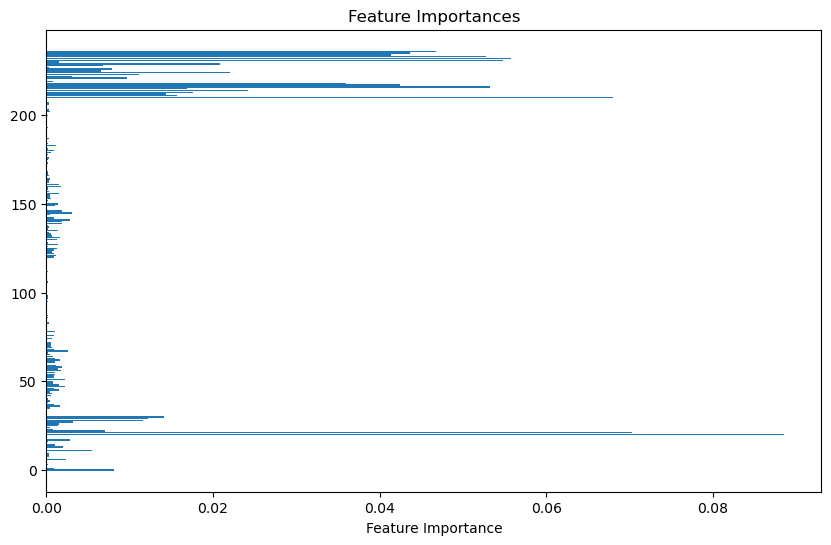

In [46]:
categorical_columns = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'zipcode']
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Handle missing values in categorical columns
X_train[categorical_columns] = X_train[categorical_columns].replace('1m', np.nan)
X_test[categorical_columns] = X_test[categorical_columns].replace('1m', np.nan)

# Fill missing values with the mode of each column
for col in categorical_columns:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_train[col].mode()[0])
    
# Fill missing values in the 'bathrooms' column with the median value
X_train['bathrooms'] = X_train['bathrooms'].fillna(X_train['bathrooms'].median())
X_test['bathrooms'] = X_test['bathrooms'].fillna(X_train['bathrooms'].median())  # Use median from X_train for consistency

# Define the column transformer with both categorical and numerical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ])

# Create the pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on training and test data
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Calculate accuracy for training and test sets
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print the results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Feature Importances from the RandomForestClassifier
model = pipeline.named_steps['classifier']
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importances")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# List to store test accuracies
max_depth_values = range(1, 21)  # Test depths from 1 to 20
test_accuracies = []

# Loop over different depths
for depth in max_depth_values:
    # Initialize the RandomForestClassifier with varying max_depth
    classifier = RandomForestClassifier(n_estimators=200, max_depth=depth, random_state=42)
    
    # Train the model
    classifier.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred_test = classifier.predict(X_test_scaled)
    
    # Calculate and store test accuracy
    accuracy = accuracy_score(y_test, y_pred_test)
    test_accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, test_accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs Max Depth of Random Forest Classifier")
plt.xlabel("Max Depth")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(max_depth_values)
plt.show()